In [179]:
import os
import numpy as np 

from plot_params import * 
from math import sqrt
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.stats import qmc

In [180]:
# define global functions

def check_inside_mandlebrot(i, c):
    z = 0 + 0j
    for _ in range(i):
        z = z ** 2 + c
        if abs(z) > 2:
            return 0
    return 1

def n_in_mandlebrot(i, s, sampling_function):
    random_complex_numbers = sampling_function(s)
    in_mandlebrot = 0
    for z in random_complex_numbers:
        in_mandlebrot += check_inside_mandlebrot(i, z)
    return in_mandlebrot

def uniform_samples(n):
    real = np.random.uniform(real_min, real_max, size=n)
    imaginary = np.random.uniform(imag_min, imag_max, size=n) * 1j
    random_complex_numbers = real + imaginary
    return random_complex_numbers

def OLHC_samples(n):
    M = int(np.sqrt(n))
    scale = 4/n
    x = np.empty(shape=(M,M))
    y = np.empty(shape=(M,M))
    m = 0
    samples = np.empty(n,dtype=np.complex_)
    for i in range(M):
        for j in range(M):
            m = m + 1
            x[i,j] = m
            y[i,j] = m
            
    for i in range(M):
        x[:,i] = permute(x[:,i],M)
        y[:,i] = permute(y[:,i],M)
 
    for i in range(M):
        for j in range(M):
            reals = -2 + scale*(x[i,j] + np.random.random(1))
            imags = -2 + scale*(y[i,j] + np.random.random(1))
            samples[M*i+j] = reals + imags*1j
    return samples

def permute(x, N):
    for i in reversed(range(1,N-1)):
        h = x[i]
        r = np.random.randint(N)
        x[i] = x[r]
        x[r] = h
    return x

def LHC_samples(n):
    sampler = qmc.LatinHypercube(d=2)
    sample = sampler.random(n=n) 
    sample = qmc.scale(sample, [real_min, imag_min], [real_max, imag_max])
    reals = sample[:, 0]
    imags = sample[:, 1]
    samples = reals + imags * 1j
    return samples


In [181]:
class DetermineNumberRuns():
    def __init__(self, n_samples, default_i, interval_length, z_value, rand_num_generator):
        self.n_samples = n_samples
        self.default_i = default_i
        self.interval_length = interval_length
        self.z_value = z_value
        self.rand_num_generator = rand_num_generator

        self.total_s = 0
        self.all_bn = 0
        self.est_area_std = 0
        self.runs_needed = 0

        self.est_area = 0

        self.all_area_std = []
        self.all_total_s = []
        self.all_stop_checks = []
        self.all_check_s = []
    
    def generate_new_values(self, n_runs):
        # calculate theta_s a couple times, add results to a list
        bn = Parallel(n_jobs=n_cores)(delayed(n_in_mandlebrot)(self.default_i, self.n_samples, self.rand_num_generator) for _ in range(n_runs))
        self.all_bn += sum(bn)
        self.total_s += n_runs * self.n_samples
        self.runs_needed += n_runs
        est_mean = self.all_bn / self.total_s
        self.est_area = est_mean * area_box
        est_var = est_mean * (1 - est_mean) / (self.total_s - 1)
        est_std = sqrt(est_var)
        self.est_area_std = area_box * est_std

        self.all_area_std.append(self.est_area_std)
        self.all_total_s.append(self.total_s)

    def keep_going(self):
        check = 2 * self.z_value * self.est_area_std# / sqrt(self.k) # what is now the treshold for 95% confidence?
        self.all_stop_checks.append(check)
        self.all_check_s.append(self.total_s)
        return check > self.interval_length
    

In [182]:
# see how fast the area converges based on the number of iterations

class IterationConvergence():
    def __init__(self, max_i, n_samples, n_runs, rand_num_generator, n_different_i):
        self.max_i = max_i
        self.n_samples = n_samples
        self.n_runs = n_runs
        self.rand_num_generator = rand_num_generator

        self.all_area_std = []
        self.all_total_s = []

        self.means = np.zeros(n_different_i)
        self.stds = np.zeros(n_different_i)
        self.all_area_means = []
        self.all_area_stds = []
        self.max_mean, self.max_std = self.determine_area(max_i)

    def determine_area(self, i):
        bn = Parallel(n_jobs=n_cores)(delayed(n_in_mandlebrot)(i, self.n_samples, self.rand_num_generator) for _ in range(self.n_runs))
        total_s = self.n_runs * self.n_samples
        mean = sum(bn) / total_s
        area_mean = mean * area_box
        var = mean * (1 - mean) / (total_s - 1)
        std = sqrt(var)
        area_std = std * area_box
        self.all_area_std.append(area_std)
        self.all_total_s.append(total_s)

        return area_mean, area_std
    
    def dist_from_max(self, i):
        mean, std = self.determine_area(i)
        mean_diff = mean - self.max_mean
        std_diff = std + self.max_std
        return mean_diff, std_diff


In [183]:
# sampling area
real_min = -2
real_max = 0.46
imag_min = -1.12
imag_max = 1.12
real_min = -2
real_max = 2
imag_min = -2
imag_max = 2
area_box = (real_max - real_min) * (imag_max - imag_min)

# settings 
n_cores = os.cpu_count()
rand_num_generator = uniform_samples
n_samples = 1000
interval_length = 0.1
z_value = 1.96
n_init_runs = 1
n_different_i = 10
min_i = 10
max_i = 20

# lists for looping
dnr_results = []
dnr_k = []
ic_mean_results = []
ic_std_results = []
i_values = np.linspace(max_i, min_i, n_different_i, dtype=int)
means = np.zeros(n_different_i)
stds = np.zeros(n_different_i)

In [184]:
for rand_num_generator in [uniform_samples, LHC_samples, OLHC_samples]:

    # determine how many runs we need in order to achieve satiffactory accuracy
    dnr = DetermineNumberRuns(n_samples, min_i, interval_length, z_value, rand_num_generator)
    dnr.generate_new_values(n_init_runs)
    while dnr.keep_going():
        dnr.generate_new_values(n_cores)
    print(f'{dnr.runs_needed} runs with {dnr.n_samples} samples needed')
    print(f'area est: {dnr.est_area} ± {dnr.est_area_std}')
    dnr_results.append(dnr.all_stop_checks)
    dnr_k.append(dnr.all_check_s)

    # check how quickly the area converges when increasing the number of iterations i
    ic = IterationConvergence(max_i, n_samples, dnr.runs_needed, rand_num_generator, n_different_i)
    for i in tqdm(range(n_different_i)):
        ic.means[i], ic.stds[i] = ic.dist_from_max(i_values[i])
    ic_mean_results.append(ic.means)
    ic_std_results.append(ic.stds)

49 runs with 1000 samples needed
area est: 2.0427755102040814 ± 0.024122162837047906


100%|██████████| 10/10 [00:00<00:00, 14.98it/s]


49 runs with 1000 samples needed
area est: 2.022530612244898 ± 0.024019735366236552


100%|██████████| 10/10 [00:00<00:00, 19.15it/s]


49 runs with 1000 samples needed
area est: 2.32065306122449 ± 0.025453305073777435


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


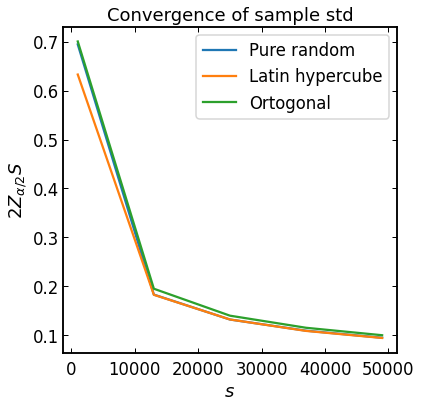

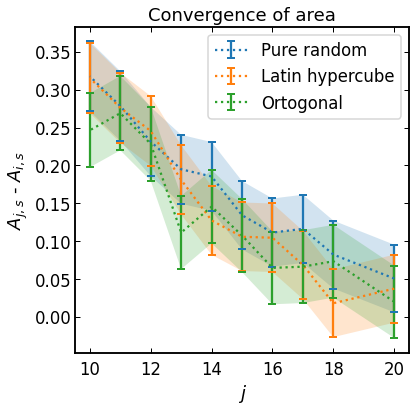

In [185]:

plt.plot(dnr_k[0], dnr_results[0], label='Pure random')
plt.plot(dnr_k[1], dnr_results[1], label='Latin hypercube')
plt.plot(dnr_k[2], dnr_results[2], label='Ortogonal')
plt.legend()
plt.title('Convergence of sample std')
plt.ylabel(r'$2 Z_{\alpha / 2} S$')
plt.xlabel('$s$')
plt.show()

plt.errorbar(i_values, ic_mean_results[0], ic_std_results[0], fmt=':', capsize=4, capthick=2, label='Pure random')
plt.fill_between(i_values, ic_mean_results[0] - ic_std_results[0], ic_mean_results[0] + ic_std_results[0], alpha=0.2)
plt.errorbar(i_values, ic_mean_results[1], ic_std_results[1], fmt=':', capsize=4, capthick=2, label='Latin hypercube')
plt.fill_between(i_values, ic_mean_results[1] - ic_std_results[1], ic_mean_results[1] + ic_std_results[1], alpha=0.2)
plt.errorbar(i_values, ic_mean_results[2], ic_std_results[2], fmt=':', capsize=4, capthick=2, label='Ortogonal')
plt.fill_between(i_values, ic_mean_results[2] - ic_std_results[2], ic_mean_results[2] + ic_std_results[2], alpha=0.2)
plt.legend()
plt.title('Convergence of area')
plt.xlabel('$j$')
plt.ylabel('$A_{j, s}$ - $A_{i, s}$')
plt.show()

# Pseudo code bepalen aantal runs:

### 1. Genereer $s$ nieuwe punten, houd het totaal bij.
### 2. Bepaal d.m.v. n_in_mandlebrot() die uitput (0, 1) heeft hoeveel er in de set zitten, houd dit ook bij.
### 3. Defineer $\theta_s = \frac{\text{aantal in de set}}{s}$, a.k.a. de gemiddelde output van n_in_mandlebrot().
### 4. Bereken de variantie $S^2$ op basis van $\theta_s$ volgens $S^2 = \frac{\theta_s (1 - \theta_s)}{s - 1}$.
### 5. Bereken de standaard afwijking $S$ op basis van deze variantie volgens $S = \sqrt{(S^2)}$.
### 6. Bereken de standaard afwijking op de oppervlakte volgens $S_{area} = S \cdot \text{Area}_{box}$
### 6. Kijk of we binnen 95% zitten door te controlen of $2 Z_{\alpha / 2} S_{area} < l$, met $l$ het acceptabele interval.
### 7. Zo niet, herhaal stap 1.


In [186]:
# problem:
""" 
Als variantie enkel afhangt van gemiddelde, dan is die voor elke sampling methode ongeveer gelijk, want de gemmideldes veranderen niet
Dit zou ook suggereren dat hoe kleiner het oppervlak, hoe minder variantie
Maar we weten dat de variantie met lhc en ortho kleiner is als we gewoon direct de oppervlakte bepalen en het de varianties daarvan uitrekenen
"""

' \nAls variantie enkel afhangt van gemiddelde, dan is die voor elke sampling methode ongeveer gelijk, want de gemmideldes veranderen niet\nMaar we weten dat de variantie met lhc en ortho kleiner is als we gewoon direct de oppervlakte bepalen en het de varianties daarvan uitrekenen\n'